Разведочный анализ данных

In [30]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random


In [ ]:
base_dir = '/Users/maks2/OneDrive/projects/retina-segmentation/Data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_image_path = os.path.join(train_dir, 'image')
train_mask_path = os.path.join(train_dir, 'mask')

test_image_path = os.path.join(test_dir, 'image')
test_mask_path = os.path.join(test_dir, 'mask')

In [ ]:
paired_train_images = []
paired_train_masks = []

for img_path in sorted(glob(os.path.join(train_image_path, '*.png'))):
    basename = os.path.basename(img_path)
    expected_mask_path = os.path.join(train_mask_path, basename)

    
    if os.path.exists(expected_mask_path):
        # Нормализуем пути для корректного сравнения
        normalized_img_path = os.path.normpath(img_path)
        normalized_mask_path = os.path.normpath(expected_mask_path)

        paired_train_images.append(normalized_img_path)
        paired_train_masks.append(normalized_mask_path)

print(f"Найдено {len(paired_train_images)} пар в тренировочной выборке")

Найдено 80 пар в тренировочной выборке


In [11]:
paired_train_images[1:10], paired_train_masks[1:10]

(['\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\1.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\10.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\11.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\12.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\13.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\14.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\15.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\16.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\17.png'],
 ['\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\mask\\1.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\mask\\10.png',
  '\\Users\\maks2\\OneDr

In [12]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(img.shape if img is not None else "Image could not be loaded")

(512, 512)


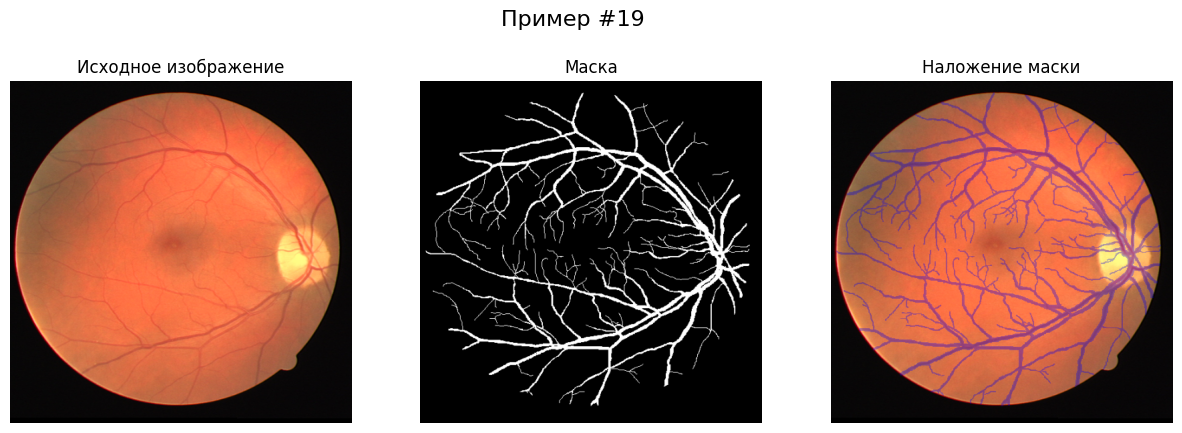

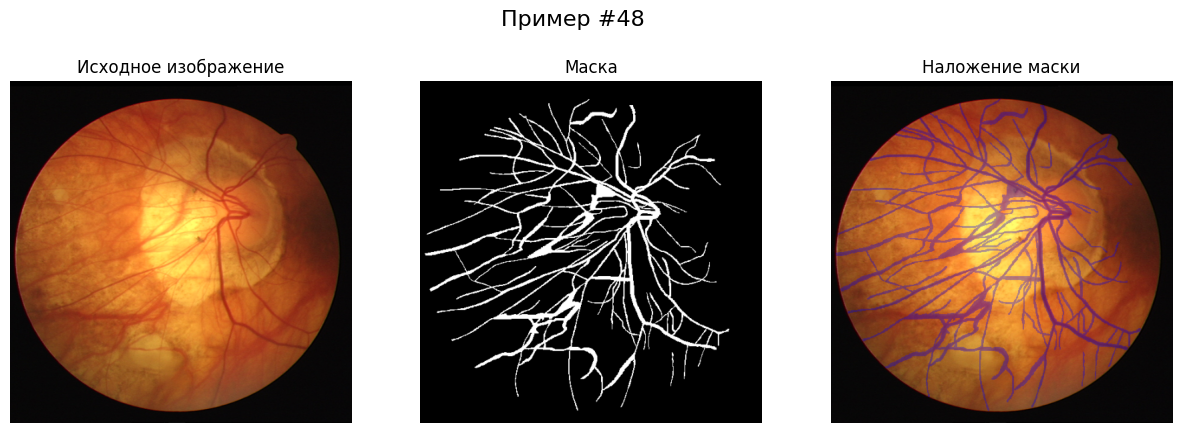

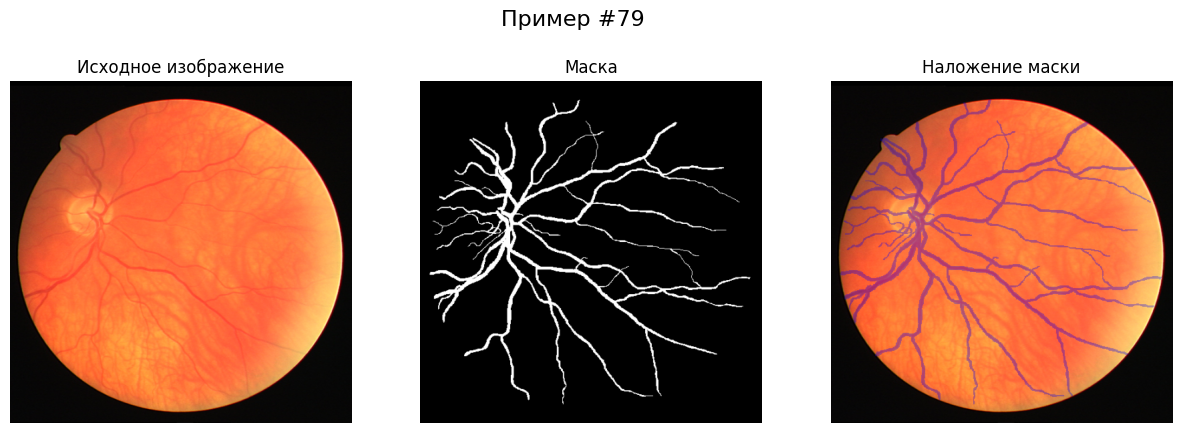

In [31]:

def visualize_sample(image, mask, title=""):
    """Накладывает маску на изображение"""
    overlay = image.copy()
    overlay[mask > 0] = (255, 0, 0) # Делаем сосуды красными
    
    # Смешиваем оригинал и маску для полупрозрачного эффекта
    blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Исходное изображение")
    ax[0].axis('off')
    
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Маска")
    ax[1].axis('off')
    
    ax[2].imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Наложение маски")
    ax[2].axis('off')
    
    fig.suptitle(title, fontsize=16)
    plt.show()

for i in range(3):
    idx = random.randint(0, len(paired_train_images) - 1)
    img = cv2.imread(paired_train_images[idx])
    mask = cv2.imread(paired_train_masks[idx], cv2.IMREAD_GRAYSCALE)
    visualize_sample(img, mask, title=f"Пример #{idx}")

In [32]:
data_info = []
for img_path, mask_path in zip(paired_train_images, paired_train_masks):
    img_shape = cv2.imread(img_path).shape
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Считаем долю пикселей, принадлежащих сосудам
    vessel_area_ratio = np.sum(mask > 0) / (mask.shape[0] * mask.shape[1])
    
    data_info.append({
        'image_path': img_path,
        'mask_path': mask_path,
        'height': img_shape[0],
        'width': img_shape[1],
        'vessel_ratio': vessel_area_ratio
    })

In [33]:
df = pd.DataFrame(data_info)
size_counts = df.groupby(['height', 'width']).size().reset_index(name='count')
print(size_counts)

if len(size_counts) > 1:
    print("Изображения имеют разные размеры")
else:
    print("Все изображения имеют одинаковый размер")

   height  width  count
0     512    512     80
Все изображения имеют одинаковый размер


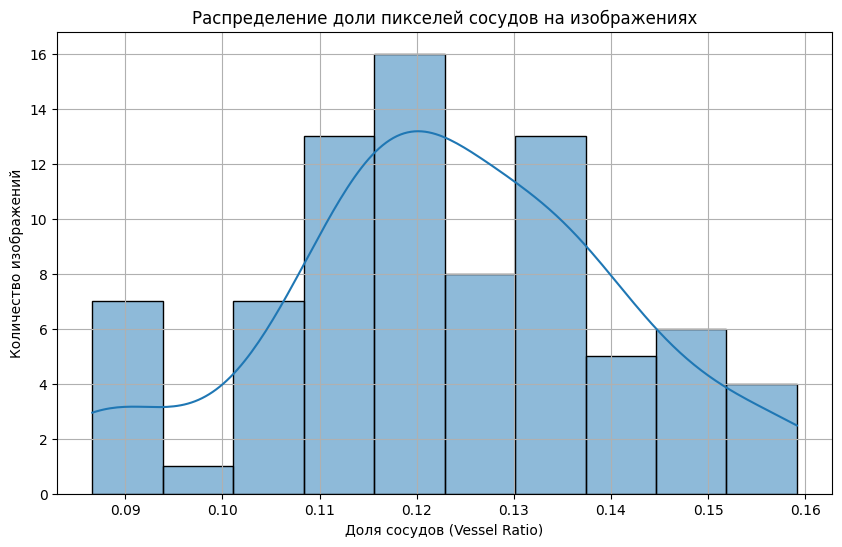

Средняя доля пикселей сосудов на изображении: 0.1232


In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(df['vessel_ratio'], bins=10, kde=True)
plt.title('Распределение доли пикселей сосудов на изображениях')
plt.xlabel('Доля сосудов (Vessel Ratio)')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

mean_ratio = df['vessel_ratio'].mean()
print(f"Средняя доля пикселей сосудов на изображении: {mean_ratio:.4f}")

In [35]:
def compute_stats(img_paths):
    """Находит mean и std для нормализации"""
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    count = 0
    
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        
        pixel_sum += img.mean(axis=(0, 1))
        pixel_sq_sum += (img**2).mean(axis=(0, 1))
        count += 1
    
    mean = pixel_sum / count
    std = np.sqrt((pixel_sq_sum / count) - mean**2)
    
    return mean, std

mean, std = compute_stats(paired_train_images)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.50390585 0.27421722 0.16436354]
Std: [0.34486165 0.18855133 0.10701356]
